In [26]:
%matplotlib inline
import re
import pythainlp
from pythainlp.ulmfit import rm_useless_newlines, rm_useless_spaces
from tqdm.notebook import tqdm
import json
import pandas as pd
import csv

# #from https://gist.github.com/korakot/01d181229b21411b0a20784e0ca20d3d
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# !pip install -U --pre matplotlib  
import matplotlib.font_manager as matfont
matfont.fontManager.addfont('thsarabunnew-webfont.ttf.1') # 3.2+
from plotnine import *
from mizani import *
theme_set(theme_minimal(14, 'TH Sarabun New'))

def process_text(content, save_txt=True):
    mapping = dict([
        #('\uf700', ''),
        ('\uf701', 'ิ'),
        ('\uf702', 'ี'),
        ('\uf703', 'ึ'),
        ('\uf704', 'ื'),
        ('\uf705', '่'),
        ('\uf706', '้'),
        ('\uf707', '๊'),
        ('\uf708', '๋'),
        ('\uf709', '์'),
        ('\uf70a', '่'),
        ('\uf70b', '้'),
        ('\uf70c', '๊'),
        ('\uf70d', '๋'),
        ('\uf70e', '์'),
        ('\uf70f', ''),
        ('\uf710', 'ัั'),
        ('\uf711', ''),
        ('\uf712', '็'),
        ('\uf713', '่'),
        ('\uf714', '้'),    
    ])
    mapping = str.maketrans(mapping)
    text = content.translate(mapping)
    text = re.sub(' า','ำ', text)
    text = pythainlp.util.normalize(text)
    text = text.strip()
    text = rm_useless_newlines(text)
    text = rm_useless_spaces(text)
    
    return text

def extract_span(text, prefix, suffix):
    pattern = re.compile(f'(?={prefix}).+(?<={suffix})')
    return rm_useless_spaces(pattern.search(text).group().split(suffix)[0].split(prefix)[1].strip())


In [2]:
#everything from 3.2
results = json.load(open('data/results32.json'))
len(results)

29105

## Extract Details of Interests

In [142]:
project_names = []
for i in tqdm(range(len(results))):
    try:
        x = process_text(results[i]['content'].replace('\n',' '))
        project_names.append(extract_span(x,'1. ชื่อโครงการ',' พื้นที่'))
    except:
        project_names.append('unk')
len(project_names)

29105

In [143]:
rationales = []
for i in tqdm(range(len(results))):
    try:
        x = process_text(results[i]['content'].replace('\n',' '))
        rationales.append(extract_span(x,'หลักการและเหตุผล','6. ที่มาของโครงการ'))
    except:
        rationales.append('unk')
len(rationales)

29105

In [156]:
scopes = []
for i in tqdm(range(len(results))):
    try:
        x = process_text(results[i]['content'].replace('\n',' '))
        scopes.append(extract_span(x,'8. ขอบเขตการ','9. ผลที่คาด'))
    except:
        scopes.append('unk')
len(scopes)

29105

In [145]:
targets = []
for i in tqdm(range(len(results))):
    try:
        x = process_text(results[i]['content'].replace('\n',' '))
        targets.append(extract_span(x,'เป้าหมายและตัวชี้วัด','10. ผู้รับผิดชอบ'))
    except:
        targets.append('unk')
len(targets)

29105

In [214]:
prices = []
for i in tqdm(range(len(results))):
    try:
        x = process_text(results[i]['content'].replace('\n',' '))
        prices.append(extract_span(x,'3. วงเงินงบประมาณ','บาท'))
    except:
        prices.append(-1)
len(prices)

29105

In [303]:
def convert_price(x):
    clean_pattern = r'[_,ก-๙ ()-]'
    res = str(x).split('(')[0]
    if 'ล้าน' in res:
        res = re.sub(r' ล้าน$','',res)
        res = re.sub(clean_pattern, '', x)
        try:
            return float(res) * 1000000
        except:
            return -1
    res = re.sub(clean_pattern, '', res)
    try:
        return float(res)
    except:
        return -1
    
def thainum_to_num(x):
    x = str(x)
    x = x.replace('๐','0')\
        .replace('๑','1')\
        .replace('๒','2')\
        .replace('๓','3')\
        .replace('๔','4')\
        .replace('๕','5')\
        .replace('๖','6')\
        .replace('๗','7')\
        .replace('๘','8')\
        .replace('๙','9')
    return x

In [325]:
#consolidate
df = pd.DataFrame({'project_name':project_names,'price':prices,'rationale':rationales,'scope':scopes,'target':targets})
df['scope'] = df.scope.map(lambda x: x.replace('ดำเนินงาน/กิจกรรมที่สำคัญของโครงการ (โปรดอธิบายให้เห็นถึงกิจกรรม-วิธีการดำเนินงาน)','')\
                           .replace('ดำเนินงาน/กิจกรรมที่สำคัญของโครงการ','')\
                           .replace('(โปรดอธิบายให้เห็นว่าโครงการที่เสนอสามารถตอบสนองวัตถุประสงค์แผนงานฟื้นฟูเศรษฐกิจและสังคม ภายใต้ พ.ร.ก.ฯ อย่างไร) ',''))
df['price_m'] = df.price.map(thainum_to_num).map(convert_price).map(lambda x: -1 if x==1 else x/1e6)
df

,project_name,price,rationale,scope,target,price_m
0,โครงการซ่อมสร้างบ้านพอเพียงผู้มีรายได้น้อยสู่ก...,"1,700.0000 ล้าน",จากสถานการณ์การแพร่ระบาดของโรคติดเชื้อไวรัสโคโ...,กิจกรรม ระยะเวลา 9 เดือน 1. การอนุมัติและเบิก...,unk,1700.0000
1,โครงการเสริมพลังกลุ่มเปราะบางทางสังคมให้มีความ...,"___1,819.3253___________ ล้าน",โครงการเสริมพลั งกลุ่ ม เปราะบางทางสั งคมให้มี...,โครงการเสริมพลังกลุ่มเปราะบางทางสังคมให้มีควา...,1. กลุ่มเปราะบางทางสังคมได้รับการเสริมพลังและพ...,1819.3253
2,โครงการพัฒนาเศรษฐกิจฐานรากและทุนชุมชนสู่เครือข...,260 ล้าน,จากผลกระทบจากสถานการณ์การระบาดของโรคติดเชื้อไว...,1.การฝึกอบรมและสร้างเครือข่าย ผู้ประสานงานพัฒ...,unk,260.0000
3,โครงการพัฒนาศูนย์การเรียนรู้ และแหล่งท่องเที่ย...,"______4,500,000 (สี่ล้านห้าแสน",(โปรดอธิบายให้เห็นว่าโครงการที่เสนอสามารถตอบสน...,ตั้งเดือนกุมภาพันธ์ 2562 เป็นต้นมาตำรวจภูธร จ...,1. เป็นแหล่งท่องเที่ยวเชิงเกษตร เป็น Land Mark...,4.5000
4,โครงการส่งเสริมอาชีพด้านเกษตรกรให้กับประชาชนใน...,"500,000",(โปรดอธิบายให้เห็นว่าโครงการที่เสนอสามารถตอบสน...,8.1 จัดทำเป็นศูนย์การเรียนรู้ด้านเกษตรกรเบื้อ...,9.1 ประชาชนที่เข้าร่วมโครงการ มีความรู้ ความสา...,0.5000
...,...,...,...,...,...,...
29100,โครงการเพิ่มมูลค่าผลผลิตการเกษตรและพัฒนาบรรจุภ...,"30๐,๐๐๐",(โปรดอธิบายให้เห็นว่าโครงการที่เสนอสามารถตอบสน...,ดําเนินงาน/กิจกรรมที่สําคัญของโครงการ (โปรดอธิ...,unk,0.3000
29101,โครงการยกระดับความสามารถในการผลิตสินค้าอตัลักษ...,-1,unk,unk,unk,-1.0000
29102,unk,-1,unk,unk,unk,-1.0000
29103,unk,"_____960,000_____________",(โปรดอธิบายให้เห็นว่าโครงการที่เสนอสามารถตอบสน...,1. กิจกรรมการปลูกฟ้าทะลายโจรเชิงการค้า ภายใต้...,1. เป็นแหล่งเรียนรู้ด้านการผลิตและการแปรรูปสมุ...,0.9600


In [326]:
#huge amount of unknown due to unsuccessful text extraction and processing 
df.apply(lambda x: (x=='unk').mean(),0)

project_name    0.574403
price           0.000000
rationale       0.653565
scope           0.684968
target          0.711940
price_m         0.000000
dtype: float64

In [327]:
(df.price_m<0).mean()

0.6137777014258718

In [20]:
# df.to_csv('data/textmaimee.csv',index=False,sep='|',quoting=csv.QUOTE_ALL)

In [308]:
df.shape

(29105, 6)

## Try to Join with Tabular Data

In [21]:
thaime = pd.read_csv('data/thaimaimee.csv')
textme = pd.read_csv('data/textmaimee.csv',sep='|')
thaime.shape,textme.shape

((33716, 9), (29105, 6))

In [22]:
joined = thaime.merge(textme,on='project_name',how='left')
joined.shape

(93883, 14)

## Explore on `textme` Only

In [23]:
textme[(textme.price_m>0)].price_m.describe()

count    1.124100e+04
mean     1.469613e+06
std      1.177643e+07
min      1.000000e-07
25%      5.000000e-01
50%      2.512000e+00
75%      1.365210e+01
max      4.537500e+08
Name: price_m, dtype: float64

In [25]:
textme

,project_name,price,rationale,scope,target,price_m
0,โครงการซ่อมสร้างบ้านพอเพียงผู้มีรายได้น้อยสู่ก...,"1,700.0000 ล้าน",จากสถานการณ์การแพร่ระบาดของโรคติดเชื้อไวรัสโคโ...,กิจกรรม ระยะเวลา 9 เดือน 1. การอนุมัติและเบิก...,unk,1700.0000
1,โครงการเสริมพลังกลุ่มเปราะบางทางสังคมให้มีความ...,"___1,819.3253___________ ล้าน",โครงการเสริมพลั งกลุ่ ม เปราะบางทางสั งคมให้มี...,โครงการเสริมพลังกลุ่มเปราะบางทางสังคมให้มีควา...,1. กลุ่มเปราะบางทางสังคมได้รับการเสริมพลังและพ...,1819.3253
2,โครงการพัฒนาเศรษฐกิจฐานรากและทุนชุมชนสู่เครือข...,260 ล้าน,จากผลกระทบจากสถานการณ์การระบาดของโรคติดเชื้อไว...,1.การฝึกอบรมและสร้างเครือข่าย ผู้ประสานงานพัฒ...,unk,260.0000
3,โครงการพัฒนาศูนย์การเรียนรู้ และแหล่งท่องเที่ย...,"______4,500,000 (สี่ล้านห้าแสน",พัฒนาพื้นที่เป็นศูนย์การเรียนรู้ และแหล่งท่องเ...,ตั้งเดือนกุมภาพันธ์ 2562 เป็นต้นมาตำรวจภูธร จ...,1. เป็นแหล่งท่องเที่ยวเชิงเกษตร เป็น Land Mark...,4.5000
4,โครงการส่งเสริมอาชีพด้านเกษตรกรให้กับประชาชนใน...,"500,000",(โปรดอธิบายให้เห็นว่าโครงการที่เสนอสามารถตอบสน...,8.1 จัดทำเป็นศูนย์การเรียนรู้ด้านเกษตรกรเบื้อ...,9.1 ประชาชนที่เข้าร่วมโครงการ มีความรู้ ความสา...,0.5000
...,...,...,...,...,...,...
29100,โครงการเพิ่มมูลค่าผลผลิตการเกษตรและพัฒนาบรรจุภ...,"30๐,๐๐๐",5.1,ดําเนินงาน/กิจกรรมที่สําคัญของโครงการ (โปรดอธิ...,unk,0.3000
29101,โครงการยกระดับความสามารถในการผลิตสินค้าอตัลักษ...,-1,unk,unk,unk,-1.0000
29102,unk,-1,unk,unk,unk,-1.0000
29103,unk,"_____960,000_____________",จากการระบาดของโรคติดเชื้อไวรัสโคโรนา 2019 ส่งผ...,1. กิจกรรมการปลูกฟ้าทะลายโจรเชิงการค้า ภายใต้...,1. เป็นแหล่งเรียนรู้ด้านการผลิตและการแปรรูปสมุ...,0.9600


### `rationale` Word Cloud

In [27]:
import pythainlp
from pythainlp.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [39]:
texts = []
for i in range(textme.shape[0]):
    texts+=[i for i in word_tokenize(textme.rationale[i], keep_whitespace=False) if len(i)>2]
text_rationale = ' '.join(texts)
text_rationale[:100]

'จาก สถานการณ์ การ แพร่ระบาด ของ โรคติดเชื้อ ไวรัส 2019 COVID ซึ่ง ความ รุนแรง เพิ่มขึ้น และ ส่ง ผลกร'

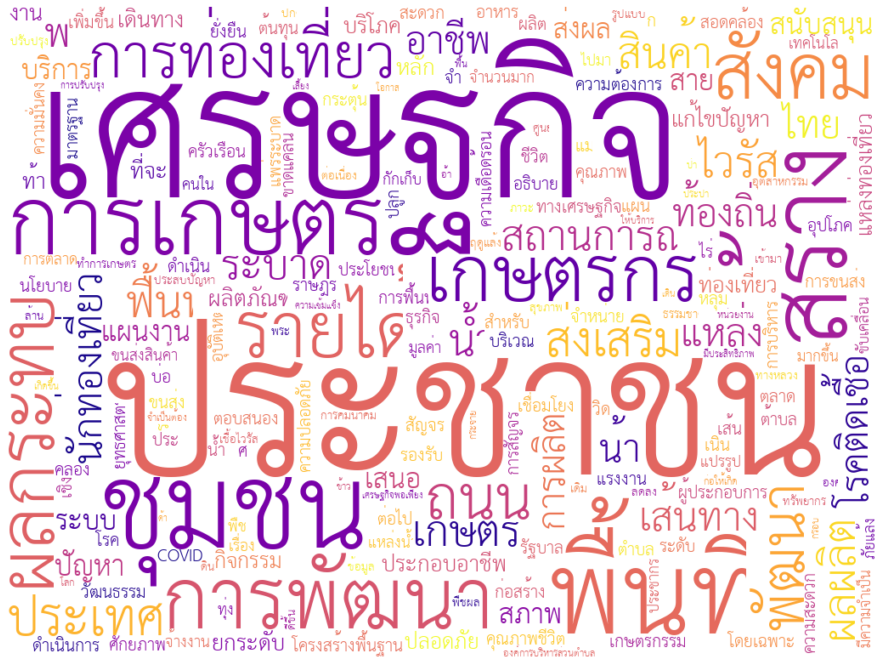

In [48]:
wordcloud = WordCloud(font_path='thsarabunnew-webfont.ttf.1',
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=200,
                      collocations=False,
                      colormap='plasma',
                      regexp=r"[ก-๙a-zA-Z']+",
                      stopwords=list(pythainlp.corpus.common.thai_stopwords()) + \
                          ['unk','โครงการ','โครง','วัตถุประสงค์','งบประมาณ',
                           #preposition
                           'ดังนั้น','โปรด',
                           #units
                          'เมตร','ตารางเมตร','ลบ','ตร','กม','บาท',
                           #area
                          'จังหวัด','เขต','อำเภอ','ตำบล','หมู่','บ้าน','เมือง',
                           'หมู่บ้าน','หนอง',
                           #size
                           'ขนาด','จำนวน','ปริมาณ']
                      ).generate(text_rationale)

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

### `scope` Word Cloud

In [41]:
texts = []
for i in range(textme.shape[0]):
    texts+=[i for i in word_tokenize(textme.scope[i], keep_whitespace=False) if len(i)>2]
text_scope = ' '.join(texts)
text_scope[:100]

'กิจกรรม ระยะเวลา เดือน การอนุมัติ และ เบิก จ่าย งบประมาณ เวที ประชาคม ระดับ ตำบล รับรอง สิทธิ ผู้ เด'

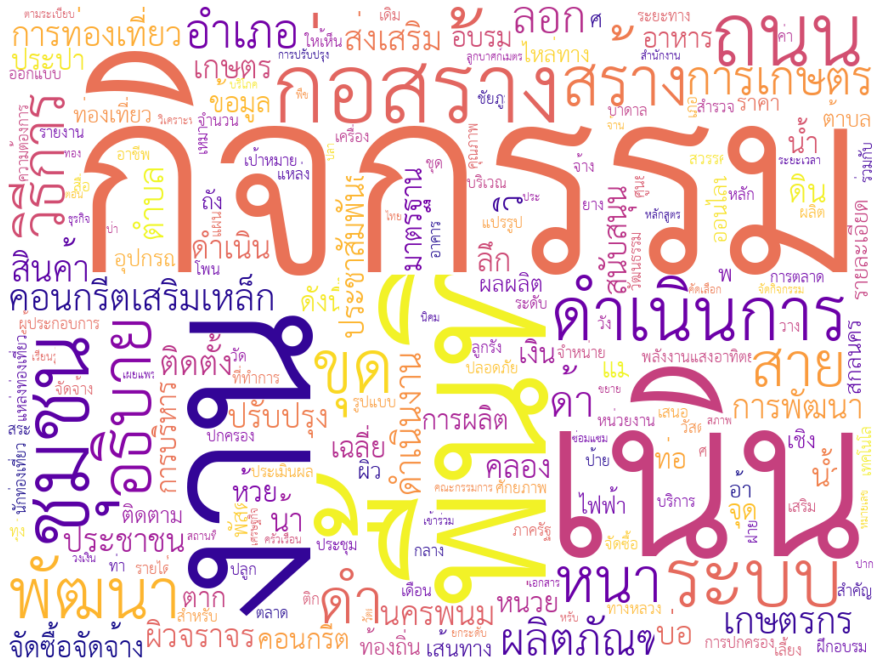

In [46]:
wordcloud = WordCloud(font_path='thsarabunnew-webfont.ttf.1',
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=200,
                      collocations=False,
                      colormap='plasma',
                      regexp=r"[ก-๙a-zA-Z']+",
                      stopwords=list(pythainlp.corpus.common.thai_stopwords()) + \
                          ['unk','โครงการ','โครง','วัตถุประสงค์','งบประมาณ',
                           #preposition
                           'ดังนั้น','โปรด',
                           #units
                          'เมตร','ตารางเมตร','ลบ','ตร','กม','บาท',
                           #area
                          'จังหวัด','เขต','อำเภอ','ตำบล','หมู่','บ้าน','เมือง',
                           'หมู่บ้าน','หนอง',
                           #size
                           'ขนาด','จำนวน','ปริมาณ']
                      ).generate(text_scope)

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

### `target` Word Cloud

In [43]:
texts = []
for i in tqdm(range(textme.shape[0])):
    texts+=[i for i in word_tokenize(textme.target[i], keep_whitespace=False) if len(i)>2]
text_target = ' '.join(texts)
text_target[:100]

'unk กลุ่ม เปราะบาง ทางสังคม ได้รับ การ เสริม พลัง และ พัฒนา ทักษะ และ ศักยภาพ ที่ เหมาะสม Reskill Up'

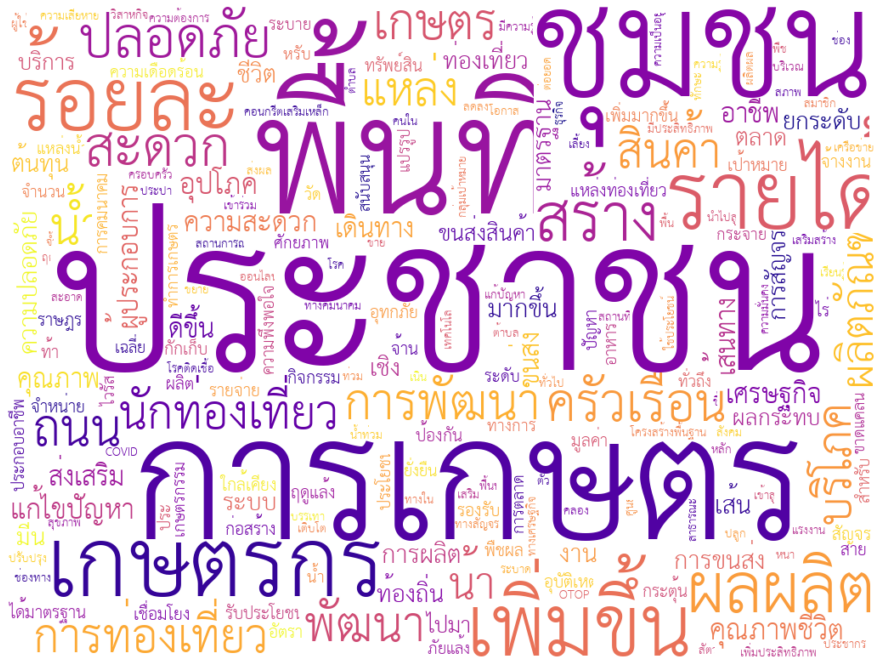

In [47]:
wordcloud = WordCloud(font_path='thsarabunnew-webfont.ttf.1',
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=200,
                      collocations=False,
                      colormap='plasma',
                      regexp=r"[ก-๙a-zA-Z']+",
                      stopwords=list(pythainlp.corpus.common.thai_stopwords()) + \
                          ['unk','โครงการ','โครง','วัตถุประสงค์','งบประมาณ',
                           #preposition
                           'ดังนั้น','โปรด',
                           #units
                          'เมตร','ตารางเมตร','ลบ','ตร','กม','บาท',
                           #area
                          'จังหวัด','เขต','อำเภอ','ตำบล','หมู่','บ้าน','เมือง',
                           'หมู่บ้าน','หนอง',
                           #size
                           'ขนาด','จำนวน','ปริมาณ']
                      ).generate(text_target)

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()